In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from keras import layers
# from keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import os
tf.__version__
tf.random.set_seed(123)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Adding data paths
parent_dir = r'/mnt/E/datasets/pneumonia_kaggle'
train_dir = os.path.join(parent_dir,'train')
test_dir = os.path.join(parent_dir,'test')
val_dir = os.path.join(parent_dir,'val')
save_dir = r'/mnt/D/Projects/Pneumonia Kaggle'

In [3]:
# Confirm that the data is balanced
norm_train = os.listdir(os.path.join(train_dir, 'NORMAL'))
pneu_train = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))
print(f"Normal: {len(norm_train)}")
print(f"Pneumonia: {len(pneu_train)}")

# The data is not balanced
diff = len(pneu_train) - len(norm_train)
print(f"Difference: {diff}")

Normal: 743
Pneumonia: 3433
Difference: 2690


In [4]:
# Do augmentation and write data to disk
# It is only used if difference between classes > 1 image
# This is to avoid repetition while enhancing the model
from scipy import ndimage
import cv2

# Use counter to stop when the difference between classes is zero
if diff > 1:
    count = diff

    norm_path = os.path.join(train_dir, 'NORMAL')
    

    for im in reversed(norm_train):

        if count > 0:
            img = cv2.imread(os.path.join(norm_path, im))

            # rotate by 5 degrees in both directions
            rotated_1 = ndimage.rotate(img, 5)
            cv2.imwrite(f"{norm_path}/augmented_r5_{im}", rotated_1)

            rotated_2 = ndimage.rotate(img, -5)
            cv2.imwrite(f"{norm_path}/augmented_r-5_{im}", rotated_2)

            # Miror the image horizontally
            flipped = cv2.flip(img, 1)
            cv2.imwrite(f"{norm_path}/augmented_f_{im}", flipped)

            # Crop the image by 5 and 10% for all sides
            crop_pix = int(max([img.shape[0], img.shape[1]])*0.05)
            crop_1 = img[crop_pix:-crop_pix, crop_pix:-crop_pix]
            cv2.imwrite(f"{norm_path}/augmented_c5_{im}", crop_1)

            crop_pix *= 2
            crop_2 = img[crop_pix:-crop_pix, crop_pix:-crop_pix]
            cv2.imwrite(f"{norm_path}/augmented_c10_{im}", crop_2)
            count -= 5
        
        else:
            break


In [5]:
# Setting parameters
batch_size = 32
img_height = 450
img_width = 450
epochs = 20

In [6]:
# Converting data directory to a training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    labels='inferred',
    color_mode='grayscale',
    seed=123,
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6866 files belonging to 2 classes.


In [7]:
# Converting data directory to a validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    labels='inferred',
    color_mode='grayscale',
    seed=123,
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 840 files belonging to 2 classes.


In [8]:
# Converting data directory to a test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    labels='inferred',
    color_mode='grayscale',
    seed=123,
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 840 files belonging to 2 classes.


In [9]:
# Getting class names
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/255)
train_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_ds = val_ds.map(lambda image,label:(rescale(image),label))
test_ds  = test_ds.map(lambda image,label:(rescale(image),label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:

# Structuring the model
num_classes = len(class_names)

callback = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=1, verbose=1, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(f"{save_dir}/pneumonia_{epochs}e_binary_801010.h5")]
model = keras.models.Sequential()
# model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32,3, activation='relu', input_shape=(img_width,img_height,1)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64,3, activation='relu', input_shape=(img_width,img_height,1)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(128,3, activation='relu', input_shape=(img_width,img_height,1)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(128,3, activation='relu', input_shape=(img_width,img_height,1)))
model.add(layers.MaxPool2D())
# model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))

# model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
# model.add(layers.Dense(num_classes))

In [12]:
model.compile(
              optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [13]:
# Fitting the model
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/20
215/215 [==============================] - 3349s 16s/step - loss: 0.2347 - accuracy: 0.8998 - val_loss: 0.2514 - val_accuracy: 0.9012
Epoch 2/20
215/215 [==============================] - 3320s 15s/step - loss: 0.1004 - accuracy: 0.9626 - val_loss: 0.2161 - val_accuracy: 0.9333
Epoch 3/20
215/215 [==============================] - 3295s 15s/step - loss: 0.0819 - accuracy: 0.9715 - val_loss: 0.1220 - val_accuracy: 0.9512
Epoch 4/20
215/215 [==============================] - 3279s 15s/step - loss: 0.0592 - accuracy: 0.9779 - val_loss: 0.1062 - val_accuracy: 0.9667
Epoch 5/20
215/215 [==============================] - 3280s 15s/step - loss: 0.0519 - accuracy: 0.9816 - val_loss: 0.1925 - val_accuracy: 0.9476
Epoch 6/20
215/215 [==============================] - 3274s 15s/step - loss: 0.0417 - accuracy: 0.9859 - val_loss: 0.2798 - val_accuracy: 0.9381
Epoch 7/20
215/215 [==============================] - 3269s 15s/step - loss: 0.0336 - accuracy: 0.9866 - val_loss: 0.2184 - val_ac

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 128)      0

In [15]:
# Save model
# model.save(f"{save_dir}/pneumonia_{epochs}e_binary_801010.h5")

In [16]:
# Load the model
# model = keras.models.load_model(f"{save_dir}/pneumonia_{epochs}e_binary_801010.h5")

In [17]:
# Model evaluation
score_test = model.evaluate(test_ds)

for name, value in zip(model.metrics_names, score_test):
    print(name, ': ', value)

27/27 [==============================] - 116s 4s/step - loss: 1.1778 - accuracy: 0.8702
loss :  1.1778048276901245
accuracy :  0.8702380657196045


In [18]:
# Getting x and y from the test set
test_preds = []
x_test = []
y_test = []
for x,y in test_ds:
    x_test.extend(x)

    test_pred = model.predict(x)
    test_preds.extend(test_pred)
    y_test.extend(y)

# Convert list to array
x_test = np.array(x_test)
preds = np.array(test_preds)
y_pred = np.where(preds > 0.5, 1, 0)
y_test = np.array(y_test)

1/1 [==============================] - 1s 1s/step


In [19]:
# Assessing model performance using confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

cm  = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred) * 100
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision * recall)/(precision + recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1-score of the model is {:.2f}".format(f1))
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

Accuracy of the model is 87.02
Recall of the model is 0.97
Precision of the model is 0.81
F1-score of the model is 0.88
TN: 322, FP: 98, FN: 11, TP: 409


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86       420
         1.0       0.81      0.97      0.88       420

    accuracy                           0.87       840
   macro avg       0.89      0.87      0.87       840
weighted avg       0.89      0.87      0.87       840



In [22]:
# Predict
# E:\Downloads\chest pneumonia.jpg
img = keras.preprocessing.image.load_img(r"/mnt/E/datasets/pneumonia_kaggle/test/PNEUMONIA/person55_bacteria_260.jpeg",
                                         target_size=(img_width, img_height),
                                         color_mode='grayscale')
img_array = keras.preprocessing.image.img_to_array(img)
print(img_array.shape)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
print(img_array.shape)
predictions = model.predict(img_array)
score = predictions[0]
print(score)
tmp_pred = np.where(score > 0.5, 1, 0)
print(tmp_pred)
print("This image is %.2f percent normal and %.2f percent pneumonia." % (100 * (1 - score), 100 * score))

(450, 450, 1)
(1, 450, 450, 1)
1/1 [==============================] - 0s 245ms/step
[1.]
[1]
This image is 0.00 percent normal and 100.00 percent pneumonia.


In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_test, y_pred)

print(auc_score1)

0.8702380952380953


/tmp/ipykernel_24955/3656010033.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


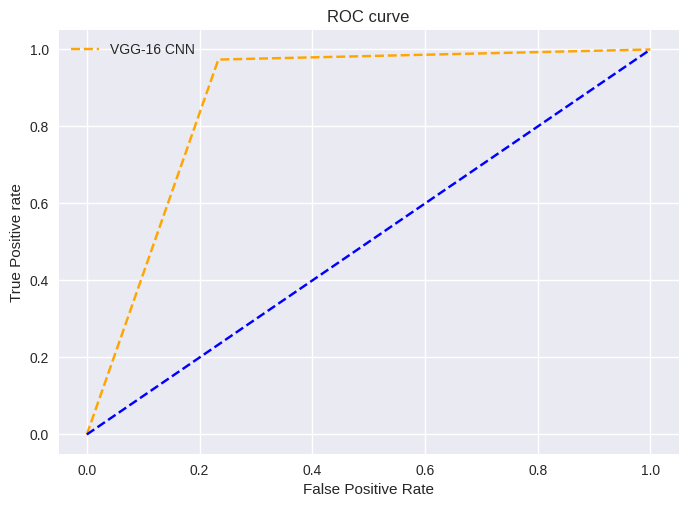

In [24]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='VGG-16 CNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();